In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pydot

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, models, layers, optimizers, metrics, regularizers
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, LeakyReLU, Dropout, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG19
#from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model


Found 325 images belonging to 5 classes.
Found 139 images belonging to 5 classes.
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_____________________________________________

Epoch 89/120
100/100 [==============================] - 118s 1s/step - loss: 0.0419 - acc: 0.9920 - val_loss: 0.1404 - val_acc: 0.9500
Epoch 90/120
100/100 [==============================] - 119s 1s/step - loss: 0.0421 - acc: 0.9860 - val_loss: 0.0752 - val_acc: 1.0000
Epoch 91/120
100/100 [==============================] - 118s 1s/step - loss: 0.0339 - acc: 0.9900 - val_loss: 0.1597 - val_acc: 0.9000
Epoch 92/120
100/100 [==============================] - 118s 1s/step - loss: 0.0976 - acc: 0.9760 - val_loss: 0.1587 - val_acc: 0.9500
Epoch 93/120
100/100 [==============================] - 119s 1s/step - loss: 0.0435 - acc: 0.9840 - val_loss: 0.1854 - val_acc: 0.9000
Epoch 94/120
100/100 [==============================] - 118s 1s/step - loss: 0.0646 - acc: 0.9780 - val_loss: 0.1586 - val_acc: 0.9000
Epoch 95/120
100/100 [==============================] - 118s 1s/step - loss: 0.0757 - acc: 0.9800 - val_loss: 0.1540 - val_acc: 0.9500
Epoch 96/120
100/100 [==============================] -

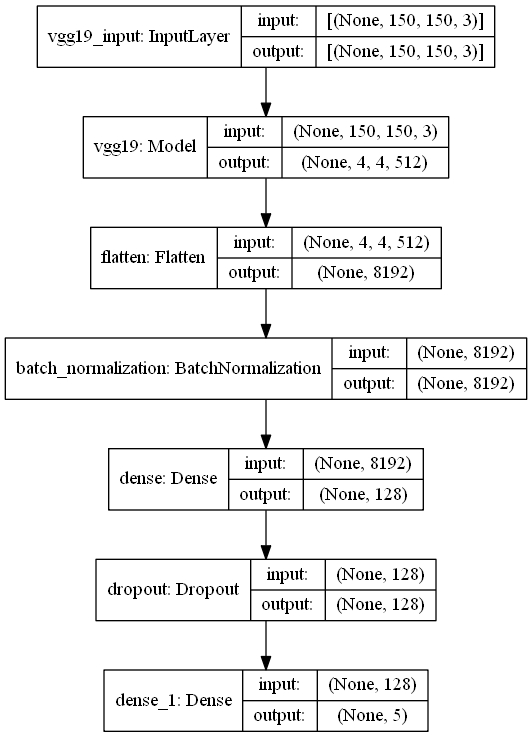

In [4]:
np.random.seed(3)
tf.compat.v1.set_random_seed(3)

train_datagen = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  rotation_range=5,
                                  shear_range=0.7,
                                  zoom_range=[0.9, 1.2],
                                  brightness_range=[0.7, 1.5],
                                  #vertical_flip=True,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
       './Data/Train/',
       target_size=(150, 150),
       batch_size=5,
       class_mode="sparse")

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
       './Data/Validation/',
       target_size=(150, 150), #어제는 100으로 뒀을 때 제제제이이이ㅣ이리리일잘나옴
       batch_size=5,
       class_mode="sparse")


transfer_model = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
#transfer_model.trainable = False
transfer_model.trainable = True
set_trainable = False
for layer in transfer_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
transfer_model.summary()

finetune_model = models.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(Flatten())
finetune_model.add(BatchNormalization())
finetune_model.add(Dense (128, activation='relu'))
finetune_model.add(Dropout(0.3))
finetune_model.add(Dense(5, activation='softmax'))
finetune_model.summary()

finetune_model.compile(loss='sparse_categorical_crossentropy', 
                       #optimizer=optimizers.SGD(lr=1E-5, momentum=0.9, nesterov=True),
                       optimizer=optimizers.Adam(learning_rate=0.00001),
                       metrics=['accuracy'])

history = finetune_model.fit_generator(
       train_generator,
       steps_per_epoch=100,
       epochs=120,  #자기전에 100번 돌려보자..
       validation_data=validation_generator,
       validation_steps=4)

finetune_model.save('HRFC_VGG19_FineTuned_Model_91.h5')
plot_model(finetune_model, to_file='finetuned_vgg19.png')
plot_model(finetune_model, to_file='finetuned_vgg191.png', show_shapes=True)

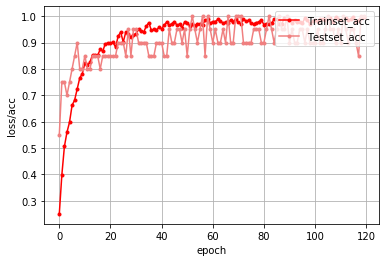

In [5]:
acc= history.history['acc']
val_acc= history.history['val_acc']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, acc, marker='.', c="red", label='Trainset_acc')
plt.plot(x_len, val_acc, marker='.', c="lightcoral", label='Testset_acc')

#x_len_2 = np.arange(len(acc))
#plt.plot(x_len, y_vloss, marker='.', c="cornflowerblue", label='Testset_loss')
#plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()


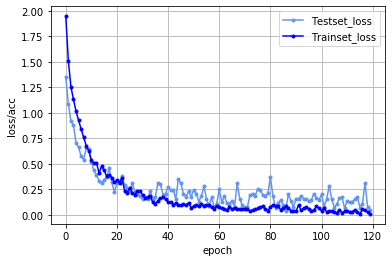

In [6]:
x_len_2 = np.arange(len(acc))
plt.plot(x_len, y_vloss, marker='.', c="cornflowerblue", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()


In [1]:
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

model = load_model('HRFC_VGG19_FineTuned_Model_91.h5')
print(model.summary())

test_datagen = ImageDataGenerator(rescale=1./255) #이미지를 0에서 1사이의 값으로 만들어줌
test_generator = test_datagen.flow_from_directory(
        './Data/Test/',
        target_size=(150, 150),
        class_mode='sparse',
        batch_size=1,
        shuffle=False)
test_loss, test_acc = model.evaluate_generator(test_generator, steps = 85)

print("test_acc:", test_acc)

probabilities = model.predict_generator(test_generator,85)
print("acc_matrix_size:", np.array(probabilities).shape)
print("test_Set_filesize:", len(test_generator.filenames))

print('-------------Test_Accuracy_Table---------------')
for i in range(len(test_generator.filenames)):
    print(probabilities[i]," : " ,test_generator.filenames[i])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
______________________________________________

예측: 중국식뱀탕


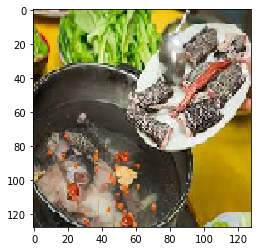

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt
cls_index = ['제육볶음', '짜장면', '국밥', '중국식박쥐탕', '중국식뱀탕']
from tensorflow.keras.preprocessing.image import array_to_img
import numpy
imgs = test_generator.next()
#print(imgs)
arr = imgs[0][0]
img = array_to_img(arr).resize((128, 128))
plt.imshow(img)
result = model.predict_classes(arr.reshape(1,150,150,3))
print('예측: {}'.format(cls_index[result[0]]))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
중국식박쥐탕입니다. 고위험군 음식입니다. 바이러스에 잠재적 위험성을 갖고 있으니 드시지 마세요.


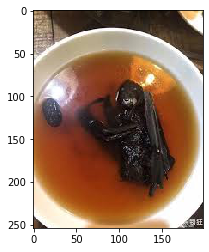

In [1]:
%matplotlib inline
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

imgg='./Data/Train/3 bat-soup/중국박쥐탕034.jpg'
model = load_model('HRFC_VGG19_FineTuned_Model_91.h5')

test_image1 = image.load_img(imgg, target_size = (150,150))
test_image2 = image.img_to_array(test_image1)
test_image2 = np.expand_dims(test_image2, axis = 0)
result = model.predict(test_image2)

origin_image = image.load_img(imgg)
plt.imshow(origin_image)

if result[0][0] == 1.0:
    print('제육볶음입니다. 저위험군 음식입니다')
elif result[0][1] == 1.0:
    print('돼지국밥입니다. 저위험군 음식입니다.')
elif result[0][2] == 1.0:
    print('짜장면입니다. 저위험군 음식입니다.\n 하지만 열량이 높아서 성인병에 좋지 않은 음식입니다.')
elif result[0][3] == 1.0:
    print('중국식박쥐탕입니다. 고위험군 음식입니다. 바이러스에 잠재적 위험성을 갖고 있으니 드시지 마세요.')
elif result[0][4] == 1.0:
    print('제육볶음입니다. 저위험군 음식입니다. 바이러스에 잠재적 위험성을 갖고 있으니 드시지 마세요.')
else:
    print('이미지를 입력해주세요')